In [1]:
# https://github.com/Nixtla/neuralforecast/blob/main/nbs/models.deepar.ipynb
# https://github.com/Nixtla/neuralforecast/blob/main/nbs/losses.pytorch.ipynb

# DeepAR

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Distribution
from torch.distributions import NegativeBinomial, Normal, Poisson
from torch.distributions import constraints
from torch.utils.data import DataLoader, TensorDataset

In [3]:
def level_to_outputs(level):
    qs = sum([[50-l/2, 50+l/2] for l in level], [])
    output_names = sum([[f'-lo-{l}', f'-hi-{l}'] for l in level], [])

    # Sort in increasing order
    sort_idx = np.argsort(qs)
    quantiles = np.array(qs)[sort_idx]
    output_names = list(np.array(output_names)[sort_idx])
    
    # Add median by default
    quantiles = np.concatenate([np.array([50]), quantiles])
    quantiles = torch.Tensor(quantiles) / 100
    output_names.insert(0, '-median')

    return quantiles, output_names

In [4]:
def normal_scale_decouple(output, loc=None, scale=None, eps: float = 0.2):
    mean, std = output
    std = F.softplus(std)
    if (loc is not None) and (scale is not None):
        mean = (mean * scale) + loc
        std = (std + eps) * scale
    return mean, std


def nbinomial_scale_decouple(output, loc=None, scale=None):
    mu, alpha = output
    mu = F.softplus(mu) + 1e-08
    alpha = F.softplus(alpha) + 1e-08
    if (loc is not None) and (scale is not None):
        mu = mu * scale + loc
        alpha = alpha / (scale + 1.)

    total_count = 1.0 / alpha
    probs = (mu * alpha / (1.0 + mu * alpha)) + 1e-8
    return total_count, probs


def poisson_scale_decouple(output, loc=None, scale=None):
    eps = 1e-10
    rate, _ = output
    if (loc is not None) and (scale is not None):
        rate = (rate * scale) + loc
    rate = F.softplus(rate) + eps
    return (rate, )
    

In [5]:
# DistributionLoss

class DistributionLoss(nn.Module):
    def __init__(
        self,
        distribution: str,
        level=[80, 90],  # Confidence levels of prediction intervals
        num_samples=1000,
        return_params=False,
        **distribution_kwargs,
    ):
        super().__init__()
        qs, output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.output_names = output_names

        available_distributions = dict(
            Normal=Normal,
            NegativeBinomial=NegativeBinomial,
            Poisson=Poisson
        )
        scale_decouples = dict(
            Normal=normal_scale_decouple,
            NegativeBinomial=nbinomial_scale_decouple,
            Poisson=poisson_scale_decouple,
        )
        param_names = dict(
            Normal=["-loc", "-scale"],
            NegativeBinomial=["-total_count", "-logits"], 
            Poisson=["-loc"],
        )
        
        assert distribution in available_distributions
        self.distribution = distribution
        self._base_distribution = available_distributions[distribution]
        self.scale_decouple = scale_decouples[distribution]
        self.param_names = param_names[distribution]
        self.outputsize_multiplier = len(self.param_names)
        self.num_samples = num_samples
        self.return_params = return_params
        if self.return_params:
            self.output_names = self.output_names + self.param_names
        self.distribution_kwargs = distribution_kwargs
        
    
    def _domain_map(self, input: torch.Tensor):
        """
        Maps output of neural network to domain of distribution loss
        """
        output = torch.tensor_split(input, self.outputsize_multiplier, dim=2)
        return output
        
    
    def get_distribution(self, distr_args, **distribution_kwargs) -> Distribution:
        distr = self._base_distribution(*distr_args, **distribution_kwargs)
        self.distr_mean = distr.mean
        
        if self.distribution in ('Poisson', 'NegativeBinomial'):
              distr.support = constraints.nonnegative
        return distr
    
    def sample(self, distr_args: torch.Tensor, num_samples=None):
        if num_samples is None:
            num_samples = self.num_samples
        
        # Instantiate Scale Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1, 2, 3, 0)  # [samples, B, H, N] -> [B, H, N, samples]
        
        # Compute mean and quantiles
        sample_mean = torch.mean(samples, dim=-1, keepdim=True)
        quants = torch.quantile(samples, self.quantiles, dim=-1)
        quants = quants.permute(1, 2, 3, 0)  # [Q, B, H, N] -> [B, H, N, Q]

        return samples, sample_mean, quants
    
    def __call__(self, y: torch.Tensor, distr_args: torch.Tensor):
        # Instantiate Scale Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
        loss_values = -distr.log_prob(y)
        return loss_values.mean()



In [6]:
class DeepARDecoder(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_size: int,
        hidden_layers: int,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        if hidden_layers == 0:
            # Linear transformation only
            layers = [nn.Linear(in_features=in_features, out_features=out_features)]
        else:
            # Input layer
            layers = [nn.Linear(in_features=in_features, out_features=hidden_size), nn.ReLU()]
            # Hidden layers
            for _ in range(hidden_layers - 2):
                layers += [nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.ReLU()]
            # Output layer
            layers += [nn.Linear(in_features=hidden_size, out_features=out_features)]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(x)


class DeepARNormal(nn.Module):
    def __init__(
        self,    
        out_seq_length: int,
        input_size: int = 1,
        encoder_n_layers: int = 2,
        encoder_hidden_size: int = 128,
        encoder_dropout: float = 0.1,
        decoder_hidden_layers: int = 0,
        decoder_hidden_size: int = 0,
        decoder_output_size: int = 2,
        trajectory_samples: int = 100,
    ):
        super().__init__()
        self.out_seq_length = out_seq_length
        self.input_size = input_size
        
        # LSTM encoder
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_dropout = encoder_dropout
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=self.encoder_hidden_size,
            num_layers=self.encoder_n_layers,
            dropout=self.encoder_dropout,
            batch_first=True
        )

        # Decoder
        self.n_samples = trajectory_samples
        self.decoder = DeepARDecoder(
            in_features=encoder_hidden_size,
            out_features=decoder_output_size,
            hidden_size=decoder_hidden_size,
            hidden_layers=decoder_hidden_layers,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden_state, _ = self.encoder(x)
        output = self.decoder(hidden_state)
        return output

In [7]:
decoder = DeepARDecoder(in_features=5, out_features=3, hidden_size=20, hidden_layers=3)
input = torch.rand((32, 6, 5))
output = decoder(input)

In [8]:
deepar = DeepARNormal(out_seq_length=16)
input = torch.randn(32, 21, 1)
output = deepar(input)

In [9]:
# Model training

# 1. Train / test split
# 2. Scale data -- standard scaling, save y_loc and y_scale
# 3. Construct sequence batches

In [10]:
import matplotlib.pyplot as plt

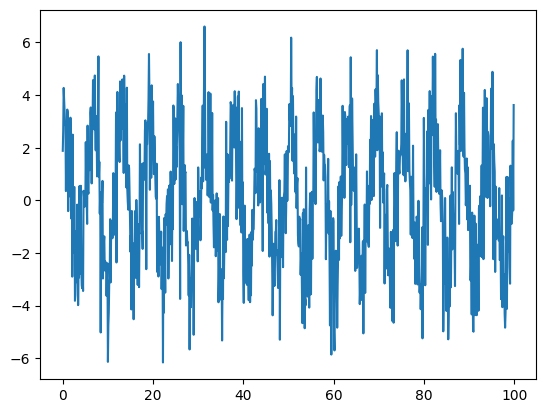

In [131]:
n_samples = 1000
xs = np.linspace(0, 100, 1000, endpoint=False)
ys = (
    np.sin(xs)
    + 2.5 * np.cos(xs)
    + np.random.normal(loc=0, scale=1.5, size=n_samples)
)

plt.plot(xs, ys)

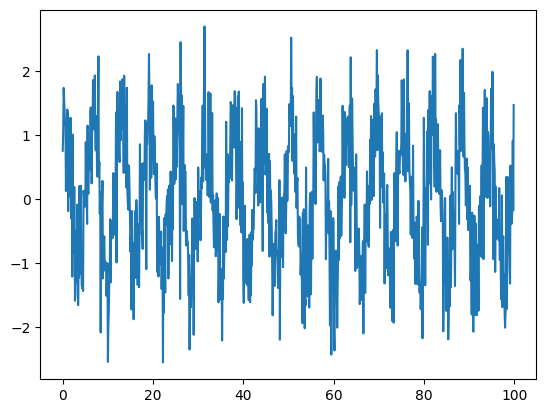

In [132]:
y_loc = np.mean(ys)
y_scale = np.std(ys)
y_scaled = (ys - y_loc) / y_scale

plt.plot(xs, y_scaled)

In [133]:
features = []
labels = []

input_seq_length = 120
output_seq_length = 1  # During training only predict a single timestamp ahead
for i in range(len(y_scaled) - input_seq_length):
    feature_seq = y_scaled[i: i + input_seq_length]
    features.append(feature_seq)
    
    for j in range(input_seq_length):
        # Labels are the unscaled observations
        label_seq = ys[i + j + 1: i + j + output_seq_length + 1]
        labels.append(label_seq)

features = np.array(features).reshape(-1, input_seq_length, 1)
labels = np.array(labels).reshape(-1, input_seq_length, 1)

In [134]:
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

In [135]:
dataset = TensorDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=32)

In [136]:
# Training loop

# Instantiate the model
deepar = DeepARNormal(out_seq_length=output_seq_length)

# Instantiate the loss func
loss_func = DistributionLoss(distribution="Normal")

# Instantiate the optimizer
optimizer = Adam(deepar.parameters(), lr=1e-03)

# Prepare model for training
deepar.train()

n_epochs = 100
for epoch in range(n_epochs):
    for X, y in dataloader:
        optimizer.zero_grad()

        # Forward
        output = deepar(X)

        # Rescale the outputs
        mean, std = torch.tensor_split(output, 2, dim=2)
        std = F.softplus(std)
        mean = (mean * y_scale) + y_loc
        std = (std + 0.2) * y_scale

        # Compute the loss
        loss_dist = Normal(loc=mean, scale=std)
        loss = (-loss_dist.log_prob(y)).mean()
        loss.backward()

        # Update weights
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
        print("------------------------------")


Epoch [0/100], Loss: 1.9948
------------------------------
Epoch [10/100], Loss: 1.9107
------------------------------
Epoch [20/100], Loss: 1.9022
------------------------------
Epoch [30/100], Loss: 1.8890
------------------------------
Epoch [40/100], Loss: 1.8416
------------------------------
Epoch [50/100], Loss: 1.8085
------------------------------
Epoch [60/100], Loss: 1.7585
------------------------------
Epoch [70/100], Loss: 1.5297
------------------------------
Epoch [80/100], Loss: 1.2534
------------------------------
Epoch [90/100], Loss: 1.0647
------------------------------


In [137]:
# Inspect the outputs
deepar.eval()

X = features[[0]]
y = labels[[0]]

with torch.no_grad():
    y_hat = deepar(X)
    mean, std = torch.tensor_split(y_hat, 2, dim=2)
    std = F.softplus(std)
    mean = (mean * y_scale) + y_loc
    std = (std + 0.2) * y_scale

distr = Normal(loc=mean, scale=std)

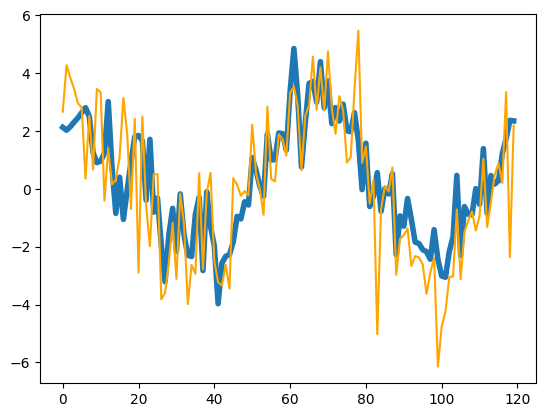

In [138]:
fig, ax = plt.subplots()
ax.plot(mean.flatten().numpy(), lw=4)
ax.plot(y.flatten().numpy(), color="orange")

In [151]:
# Forecast
input = features[[0]]  # [1, input_seq_length, 1]
horizon = 10

deepar.eval()
with torch.no_grad():
    forecasts = []
    for h in range(horizon):
        output = deepar(input)  # [1, input_seq_length, distr_params]
        output = output[:, -1, :].view(-1, 1, 2)  # Only keep next out-of-sample prediction
        
        mean, std = torch.tensor_split(output, 2, dim=2)
        std = F.softplus(std)
        
        distr = Normal(loc=mean, scale=std)
        forecast = distr.sample()
        forecasts.append(forecast)

        input = torch.cat((input, forecast), dim=1)

forecasts = torch.cat(forecasts, dim=1)
forecasts = forecasts * y_scale + y_loc

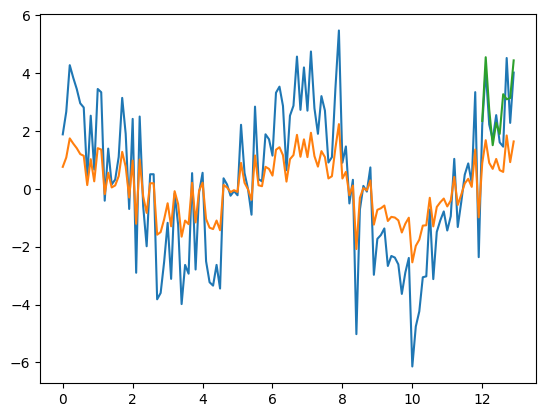

In [152]:
plt.plot(xs[:input_seq_length + horizon], ys[:input_seq_length + horizon])
plt.plot(xs[:input_seq_length + horizon], y_scaled[:input_seq_length + horizon])
plt.plot(xs[input_seq_length:input_seq_length + horizon], forecasts.flatten().numpy())

In [99]:
std

tensor([[[1.9139e-06]]])